In [1]:
import sys
import os
import json
import pandas as pd


# Change dir to root dir
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(parent_dir)
print("Current Working Directory:", os.getcwd())

from src.data import generate_df, convert_to_gdf, generate_gdf, preprocess_df
from src.plot import plot_data
from src.model import light_gbm, predict_light_gbm_model
from src.data import generate_df, generate_gdf, preprocess_df, preprocess_gdf, filter_nam_outside_vri, get_nam_outside_vri_nearest_station
from src.scripts.generateNamCSV import generate_nam_csv
from src.scripts.generateElevationCSV import generate_elevation_csv


Current Working Directory: /home/khidayat/private/submit/SDGE_NAM_Analysis


In [2]:
with open('config/data_params.json') as fh:
        data_params = json.load(fh)    

raw_data_path = [os.path.join('./data/raw', file_path) for file_path in data_params["raw_data"]]
modified_data_path = [os.path.join('./data/modified', file_path) for file_path in data_params["modified_data"]]
output_model_path = [os.path.join('./data/modified', file_path) for file_path in data_params["model_prediction"]]

In [3]:
# Reading raw data
gis_weather_station, src_vri_snapshot, nam, windspeed_snapshot = generate_df(raw_data_path) 
gis_weather_station, windspeed_snapshot = preprocess_df(gis_weather_station, windspeed_snapshot)

# Reading filtered data with elevation from API
gis_weather_station_with_elevation, nam_with_elevation = generate_df(modified_data_path)
gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_with_elevation_gpd = generate_gdf(
    gis_weather_station_with_elevation, src_vri_snapshot, nam_with_elevation)

# Readiing data from LightGBM model
nam_within_vri_prediction, nam_outside_vri_prediction = generate_df(output_model_path)

Weather Station CRS:    EPSG:4326
VRI Polygon CRS:        EPSG:4326
NAM CRS:                EPSG:4326


/home/khidayat/private/submit/SDGE_NAM_Analysis/src/data.py:9: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  return [pd.read_csv(file) for file in input_list]


## Raw Data

In [4]:
gis_weather_station.describe()

,objectid,scadartuid,district,symbolrotation,latitude,longitude,elevation,twinguid,hftd,gdb_geomattr_data,shape_srid
count,221.000000,220.000000,218.000000,221.0,221.000000,221.000000,221.000000,0.0,221.000000,0.0,221.0
mean,112.615385,4123.390909,3.467890,0.0,33.025293,-116.879246,1899.036199,NaN,2.402715,NaN,4431.0
std,64.996724,2748.069765,1.007518,0.0,0.251600,0.280545,1312.025266,NaN,0.684764,NaN,0.0
min,1.000000,1900.000000,1.000000,0.0,32.541970,-117.753500,12.000000,NaN,1.000000,NaN,4431.0
25%,57.000000,1965.750000,3.000000,0.0,32.830103,-117.075749,771.000000,NaN,2.000000,NaN,4431.0
50%,112.000000,4822.500000,3.000000,0.0,33.036349,-116.895280,1602.000000,NaN,3.000000,NaN,4431.0
75%,168.000000,5145.250000,4.000000,0.0,33.235369,-116.682487,2800.000000,NaN,3.000000,NaN,4431.0
max,241.000000,19200.000000,7.000000,0.0,33.569545,-116.037800,5795.000000,NaN,3.000000,NaN,4431.0


There are 221 unique weather stations in the gis_weather_station dataset.

In [5]:
src_vri_snapshot.describe()

,tessellate,extrude,visibility,circuit,tlid,gust_99pct,gust_95pct,gust_max,shape_length,shape_area,shape_srid
count,308.0,308.0,308.0,7.000000,102.000000,235.000000,235.000000,235.000000,308.000000,3.080000e+02,308.0
mean,-1.0,0.0,-1.0,232.428571,10533.303922,39.957447,31.757447,50.217021,33677.706147,1.444339e+07,4326.0
std,0.0,0.0,0.0,109.515383,10216.658048,9.092491,7.909524,12.552783,31366.590677,2.037987e+07,0.0
min,-1.0,0.0,-1.0,79.000000,610.000000,16.000000,13.000000,16.000000,465.600900,2.682250e+03,4326.0
25%,-1.0,0.0,-1.0,212.000000,686.750000,33.500000,26.000000,42.000000,15877.189814,3.978992e+06,4326.0
50%,-1.0,0.0,-1.0,212.000000,6940.500000,40.000000,32.000000,49.000000,24773.498418,9.369231e+06,4326.0
75%,-1.0,0.0,-1.0,231.500000,13837.500000,45.500000,36.000000,55.000000,40940.258267,1.766567e+07,4326.0
max,-1.0,0.0,-1.0,449.000000,50003.000000,79.000000,73.000000,105.000000,258860.886708,2.185812e+08,4326.0


There are 308 VRI polygons with an average area size of 1.444339e+07 km2 in the src_vri_snapshot.

In [6]:
print(f"Unique NAM dates: {nam['date'].nunique()}")
nam.describe()

Unique NAM dates: 179


,latitude,longitude,average_wind_speed
count,1.569697e+07,1.569697e+07,1.569697e+07
mean,3.325496e+01,-1.179237e+02,1.414428e+01
std,1.064321e+00,1.853296e+00,7.878578e+00
min,3.145448e+01,-1.209147e+02,0.000000e+00
25%,3.235321e+01,-1.195482e+02,8.232944e+00
50%,3.319830e+01,-1.180756e+02,1.262465e+01
75%,3.408098e+01,-1.162676e+02,1.837550e+01
max,3.534887e+01,-1.145926e+02,6.777456e+01


There are 15,696,970 unique rows of latitude, longitude, date, and wind speed that spans across 179 unique dates.

In [7]:
print(f"Unique Weather Station dates: {windspeed_snapshot['date'].nunique()}")
windspeed_snapshot.describe()

Unique Weather Station dates: 179


,wind_speed
count,29939.000000
mean,25.781689
std,11.404618
min,3.000000
25%,17.000000
50%,24.000000
75%,32.000000
max,101.000000


There are 29,939 wind speeds spanning across 179 unique dates

### Raw Data - Missing Data

In [8]:
gis_weather_station.isna().sum()

objectid                0
weatherstationcode      0
weatherstationname      0
scadartuid              1
structureid             5
nwszone                 0
district                3
thomasbrospagegrid      2
constructionstatus      0
creationuser            0
datecreated             0
datemodified            3
lastuser                3
structureguid           6
symbolrotation          0
latitude                0
longitude               0
elevation               0
twinguid              221
hftd                    0
zone1idc                0
hftdidc                 0
gdb_geomattr_data     221
globalid                0
shape                   0
shape_srid              0
snapshot_date           0
dtype: int64

In [9]:
src_vri_snapshot.isna().sum()

name                0
tessellate          0
extrude             0
visibility          0
globalid           81
anemometer          0
anemometercode    100
circuit           301
district           38
secdevice         301
structureid       107
tlid              206
gust_99pct         73
gust_95pct         73
gust_max           73
vri_risk            1
loaddate           81
county             79
hftd                0
hftdidc             0
zone1idc            0
globalid_1          0
shape_length        0
shape_area          0
shape               0
shape_srid          0
snapshot_date       0
geometry            0
dtype: int64

There are missing values in the gis_weather_station and src_vri_snapshot dataset. However, since the columns with missing values are not used in the analysis, imputation of these columns can be omitted.

In [10]:
nam.isna().sum()

latitude              0
longitude             0
date                  0
average_wind_speed    0
dtype: int64

In [11]:
windspeed_snapshot.isna().sum()

date             0
wind_speed       0
station          0
snapshot_date    0
dtype: int64

There are no missing data in the nam and windspeed_snapshot since the missing values has been omitted from the dataset by calling the preprocess_df function.

### Raw Data - Duplicate Data

In [12]:
print(gis_weather_station.duplicated().sum())
print(src_vri_snapshot.duplicated().sum())
print(nam.duplicated().sum())
print(windspeed_snapshot.duplicated().sum())

0
0
0
0


None of the raw dataset contain duplicate values.

### Raw Data - Data Type

In [13]:
print(f"NAM date data type: {nam['date'].iloc[0]}")
print(f"NAM date data type: {type(nam['date'].iloc[0])}")
print()
print(f"Weather Station date data type: {windspeed_snapshot['date'].iloc[0]}")
print(f"Weather Station date data type: {type(windspeed_snapshot['date'].iloc[0])}")

NAM date data type: 2012-09-14
NAM date data type: <class 'str'>

Weather Station date data type: 9/14/2012
Weather Station date data type: <class 'str'>


The date format is different between the NAM data and the Weather Station data. The date format will be standardized during data processing to enable accurate date comparison.

### Raw Data - Data Distribution

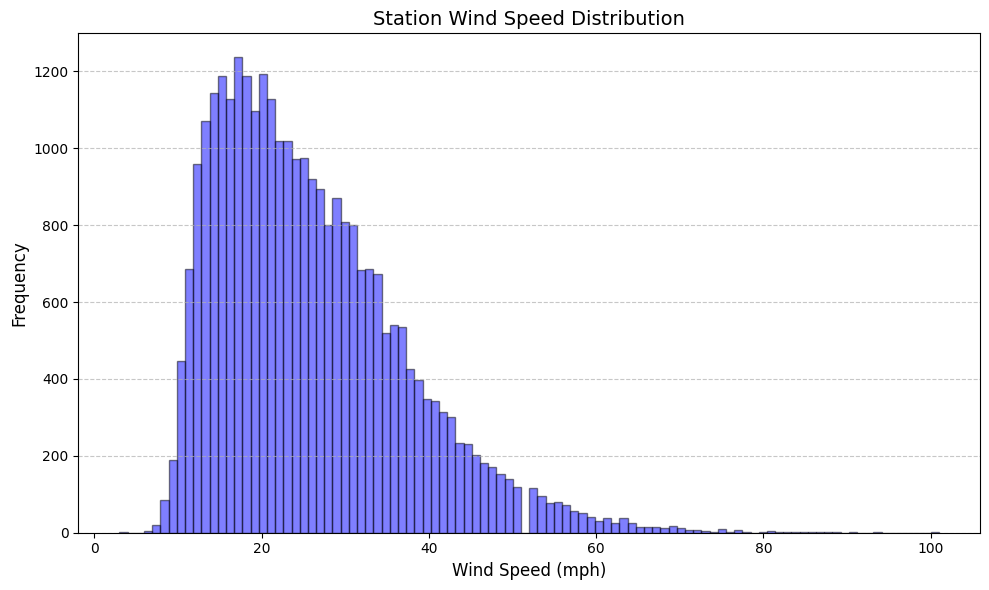

In [14]:
plot_data(windspeed_snapshot, x="wind_speed", plot_type="hist", title="Station Wind Speed Distribution", 
          xlabel="Wind Speed (mph)", ylabel="Frequency", bins=100)

Based on the histogram, the weather station wind speed is right-skewed centered at 24mph.

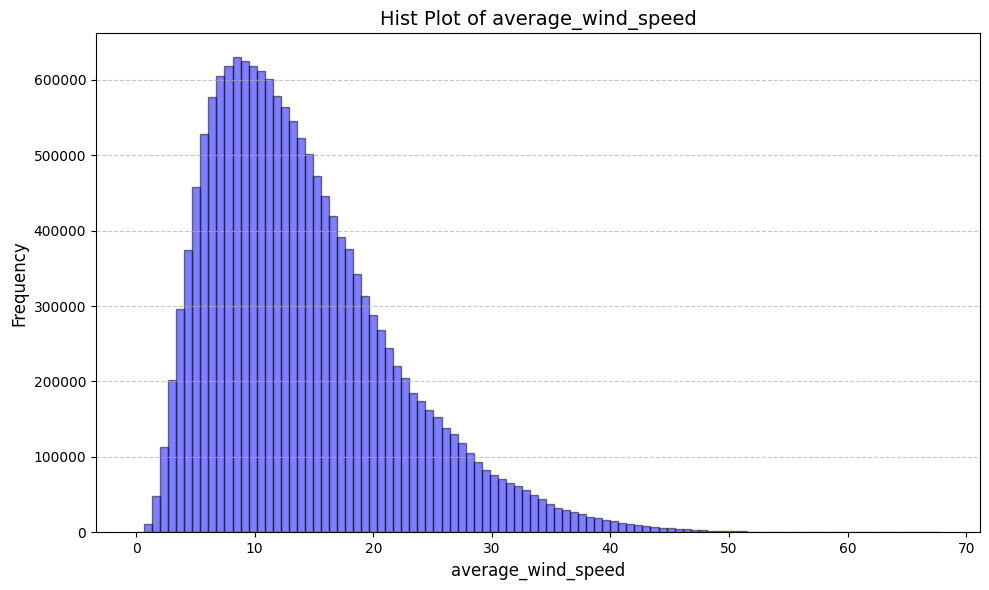

In [15]:
plot_data(nam, x="average_wind_speed", plot_type="hist", bins=100)

Based on the histogram, the nam wind speed is right-skewed centered at 14mph.

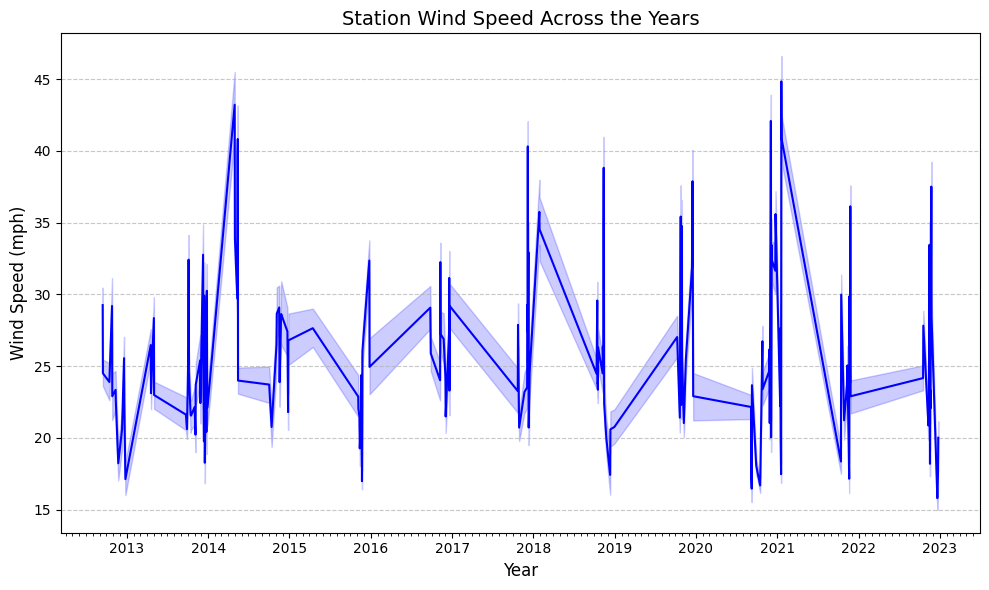

In [16]:
plot_data(windspeed_snapshot, x='date', y='wind_speed', plot_type="line", title="Station Wind Speed Across the Years", 
          xlabel="Year", ylabel="Wind Speed (mph)")

In [17]:
# plot_data(nam, x='date', y='average_wind_speed', plot_type="line", title="NAM Wind Speed Across the Years", 
#           xlabel="Year", ylabel="Wind Speed (mph)")

This line plot shows that the weather station wind speed tend to change throughout the year. This highlight the importance of capturing the temporal features in the model.

In [ ]:

model_input_file_path = modified_data_path + [raw_data_path[1], raw_data_path[3]]
gis_weather_station_with_elevation, nam_with_elevation, src_vri_snapshot, windspeed_snapshot = generate_df(model_input_file_path)
gis_weather_station_with_elevation, windspeed_snapshot = preprocess_df(gis_weather_station_with_elevation, windspeed_snapshot)
gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_with_elevation_gpd = generate_gdf(gis_weather_station_with_elevation, src_vri_snapshot, nam_with_elevation)

model_input_gdf = preprocess_gdf(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_with_elevation_gpd, windspeed_snapshot)

Weather Station CRS:    EPSG:4326
VRI Polygon CRS:        EPSG:4326
NAM CRS:                EPSG:4326


In [ ]:
model_input_gdf